In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

In [2]:
def fileO(x,y,filename):
    f = open(filename,'w');
    for i in range(len(y)):
        f.write('%.4e\t%.4e\n'%(x[i],y[i]));
    f.close();

In [3]:
# SDOF Transient Response (ISO 18431-4)
# th_in : acceleration time history at base
# th_out : acceleration time history at mass
def SDOF_ISO(th_in,dt,fn,zeta):

    wn = 2*np.pi*fn;
    wd = wn*np.sqrt(1-zeta**2);
    A=wn*dt*zeta;
    B=wd*dt;
    
    a, b = np.zeros(3), np.zeros(3);

    b[0] = 1 - np.exp(-A)*np.sin(B)/B;
    b[1] = 2*np.exp(-A)*(np.sin(B)/B - np.cos(B));
    b[2] = np.exp(-2*A) - np.exp(-A) * np.sin(B)/B;

    a[0] = 1;
    a[1] = -2*np.exp(-A)*np.cos(B);
    a[2] = np.exp(-2*A);

    th_out=lfilter(b, a, th_in, axis=-1, zi=None);
    
    return th_out;

In [4]:
## SRS (ISO 18431-4)
def srs_iso(ft,th,dr,dt):
    nf = len(ft);
    rs = np.zeros(nf);
    for i in range(nf):
        rs[i]= max(abs(SDOF_ISO(th,dt,ft[i],dr)));
    return ft,rs;

In [5]:
def rs2th_sine(ft,rt,noct,damp,tmax,it):
    
    zpa = rt[-1];
    fmin = min(ft); fmax = max(ft);
    nfreq = int(np.ceil(np.log(fmax/fmin)/np.log(2)/noct))-1;
    freq = np.zeros(nfreq);
    freq[0] = fmin*(2**noct);
    for i in range(1,nfreq):
        freq[i] = freq[i-1]*(2**noct);
    freq = np.sort(np.concatenate([freq,ft]));
    nfreq = len(freq);    
    ## log-log interpolation
    rs = 10**np.interp(np.log10(freq),np.log10(ft),np.log10(rt));
    plt.loglog(freq,rs,'b.');
    ## Initial TH
    An = np.copy(rs);
    wn = 2*np.pi*freq;
    phin = np.random.uniform(-np.pi/2,np.pi/2,nfreq);
    dt = 1/(20*fmax); t = np.arange(0,tmax+dt,dt);
    th = np.zeros(len(t));
    ## Intensity function
    itf = np.ones(len(th)); 
    itf[:int(len(th)/4)] = np.linspace(0,1,int(len(th)/4)); 
    itf[-int(len(th)/4):] = np.linspace(1,0,int(len(th)/4));
    for i in range(len(t)):
        for j in range(nfreq):
            th[i] += An[j]*np.sin(wn[j]*t[i]+phin[j]);
    freq,rs_syn = srs_iso(freq,th,damp,dt);
    # Start Iteration
    trial = np.linspace(1,it,it); 
    error = np.zeros(it);
    for k in range(it):
        for i in range(nfreq):
            An[i] *= rs[i]/rs_syn[i];
        th = np.zeros(len(t));
        for i in range(len(t)):
            for j in range(nfreq):
                th[i] += An[j]*np.sin(wn[j]*t[i]+phin[j]);
        th *= itf;
        # for i in range(len(th)):
        #    if th[i] > zpa:
        #        th[i] = zpa; # th 최대값이 zpa 초과하면 zpa 보다 작게 수정
        #    if -th[i] > zpa:
        #        th[i] = -zpa;
        freq,rs_syn = srs_iso(freq,th,damp,dt);
    
        error[k] = np.linalg.norm(rs-rs_syn);
    return freq,rs,rs_syn,trial,error,th,t;

In [6]:
# RVCH 
ft = np.array([1,  10, 20, 100.0]);  # frequency table
rt = np.array([1,  15, 15,  2]);  # response spectrum table

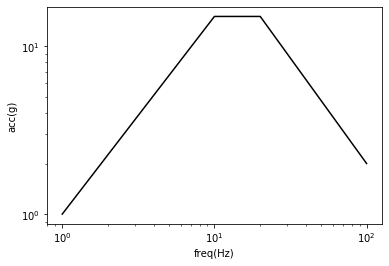

In [7]:
plt.loglog(ft,rt,'k-');
plt.xlabel('freq(Hz)'); plt.ylabel('acc(g)');

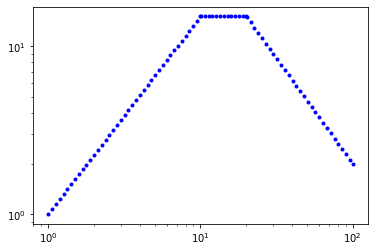

In [8]:
freq,rs,rs_syn,trial,error,th,t = rs2th_sine(ft,rt,1/12,0.02,20,10);

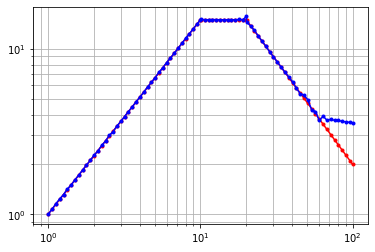

In [9]:
plt.loglog(freq,rs,'r.-');
plt.loglog(freq,rs_syn,'b.-');
plt.grid(which='both');

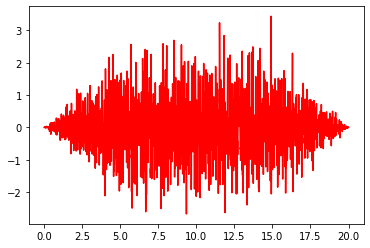

In [10]:
plt.plot(t,th,'r-');

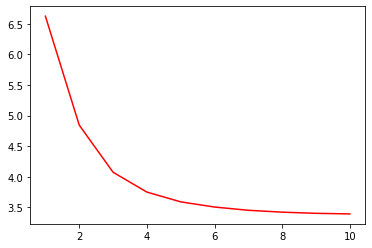

In [11]:
plt.plot(trial,error,'r-');

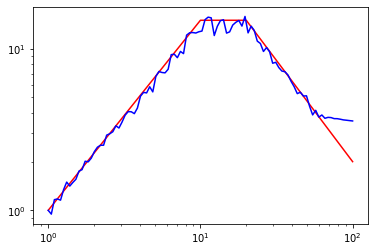

In [12]:
ft1 = np.logspace(0,2,100);
ft2,rs2 = srs_iso(ft1,th,0.02,1/2000);
plt.loglog(freq,rs,'r-');
plt.loglog(ft2,rs2,'b-');

In [13]:
fileO(ft2,rs2,"head_resp_comp1.txt");
fileO(t,th,"head_th_syn1.txt");

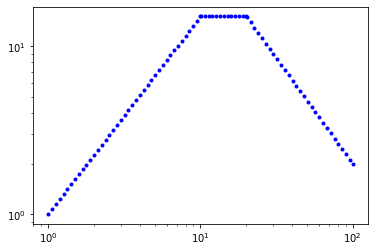

In [15]:
freq,rs,rs_syn,trial,error,th,t = rs2th_sine(ft,rt,1/12,0.02,20,10);
ft1 = np.logspace(0,2,100);
ft2,rs2 = srs_iso(ft1,th,0.02,1/2000);
fileO(ft2,rs2,"head_resp_comp2.txt");
fileO(t,th,"head_th_syn2.txt");

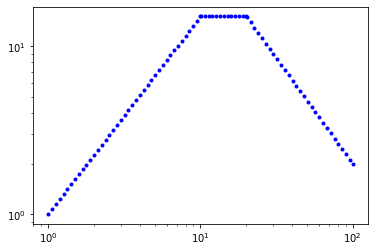

In [16]:
freq,rs,rs_syn,trial,error,th,t = rs2th_sine(ft,rt,1/12,0.02,20,10);
ft1 = np.logspace(0,2,100);
ft2,rs2 = srs_iso(ft1,th,0.02,1/2000);
fileO(ft2,rs2,"head_resp_comp3.txt");
fileO(t,th,"head_th_syn3.txt");

In [17]:
# Seismic Support
ft = np.array([1,  7, 40, 100]);  # frequency table
rt = np.array([1,  20, 20,  2]);  # response spectrum table

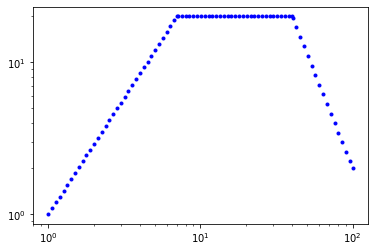

In [18]:
freq,rs,rs_syn,trial,error,th,t = rs2th_sine(ft,rt,1/12,0.02,20,10);
ft1 = np.logspace(0,2,100);
ft2,rs2 = srs_iso(ft1,th,0.02,1/2000);
fileO(ft2,rs2,"ss_resp_comp1.txt");
fileO(t,th,"ss_th_syn1.txt");

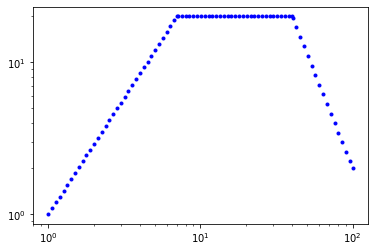

In [19]:
freq,rs,rs_syn,trial,error,th,t = rs2th_sine(ft,rt,1/12,0.02,20,10);
ft1 = np.logspace(0,2,100);
ft2,rs2 = srs_iso(ft1,th,0.02,1/2000);
fileO(ft2,rs2,"ss_resp_comp2.txt");
fileO(t,th,"ss_th_syn2.txt");